<a href="https://colab.research.google.com/github/SHINGSkywallker/project/blob/main/%E7%A8%8B%E5%BC%8F%E8%A8%AD%E8%A8%88%E5%B0%88%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. 輸入參數 (W, D, L, h)

此程式碼塊用於獲取房間和地板的尺寸輸入。

In [7]:
W = float(input("請輸入房間寬度 (W) (cm): "))
D = float(input("請輸入房間深度 (D) (cm): "))
L = float(input("請輸入地板長邊 (L) (cm): "))
h = float(input("請輸入地板短邊 (h) (cm): "))

print(f"Room Width (W): {W} cm")
print(f"Room Depth (D): {D} cm")
print(f"Floorboard Length (L): {L} cm")
print(f"Floorboard Width (h): {h} cm")

請輸入房間寬度 (W) (cm): 699
請輸入房間深度 (D) (cm): 358
請輸入地板長邊 (L) (cm): 152
請輸入地板短邊 (h) (cm): 18.1
Room Width (W): 699.0 cm
Room Depth (D): 358.0 cm
Floorboard Length (L): 152.0 cm
Floorboard Width (h): 18.1 cm


### 2. 計算所需地板排數

根據房間深度 (D) 和地板短邊 (h)，計算鋪設整個房間所需的總地板排數。

In [8]:
import math

total_rows = math.ceil(D / h)

print(f"Total number of flooring rows required: {total_rows}")

Total number of flooring rows required: 20


### 3. 材料損耗計算函數 (`calculate_material_loss`)

此函數根據新的鋪設規則進行了更新，它會管理剩餘材料池。每個循環中的每一排都以不同長度的地板起始，遵循循環模式。鋪設每排時，優先從池中選擇最合適的剩餘材料來完成鋪設，並將切割後的剩餘材料放回池中。未使用的剩餘材料最終會計入總損耗。

In [9]:
import math

def calculate_material_loss(n, W, L):
    """
    計算 'n' 個循環的平均材料損耗，考慮剩餘材料池。
    每個循環中的每一排都以不同長度的地板起始，遵循循環模式。
    鋪設每排時，中間使用整張地板，最後一塊優先從起始塊裁切後的剩餘材料池中選擇。

    參數:
        n (int): 循環次數 (模擬的排數，起始長度會循環)。
        W (float): 房間寬度。
        L (float): 單塊地板的長度。

    返回:
        float: 每排的平均材料損耗。
    """
    total_actual_loss = 0.0 # 累計總損耗
    # 這個池將專門儲存來自 『n 個起始塊模式切割』時產生的剩餘材料。
    # 這是規則中「之前開頭分等分時最接近的長度的裁切過的地板尾端來湊」的來源。
    # 並且，這個池是針對這 n 個循環建立的，不會被後續每排起始切割的剩料所填充。
    start_pattern_offcut_pool = []

    # 輔助函式：將剩餘材料加入池中並保持排序 (由大到小)
    def add_to_pool(pool, length):
        if length > 0.001: # 忽略極小的片段，避免浮點數誤差
            pool.append(length)
            pool.sort(reverse=True)

    # 輔助函式：從池中找到最適合填補空間的剩餘材料
    # 最適合的定義為：長度大於或等於 `available_space` 且長度最短接近 `available_space` 的材料
    def get_best_remnant_for_fill(pool, available_space):
        best_remnant_idx = -1
        min_over_cut_length = float('inf') # 尋找超出所需長度最短的材料
        for i, r_len in enumerate(pool):
            if r_len >= available_space: # 必須能夠覆蓋所需空間
                current_over_cut = r_len - available_space
                if current_over_cut < min_over_cut_length: # 選擇超出長度最小的
                    min_over_cut_length = current_over_cut
                    best_remnant_idx = i
        if best_remnant_idx != -1:
            return pool.pop(best_remnant_idx) # 從池中移除並返回
        return None

    # Step 1: 根據「將每一排的第一片地板依照整數分為n等分」的模式，
    # 預先生成這 n 種起始塊的裁切動作，並將其產生的所有 offcuts 放入一個池中。
    # 這個池代表了「之前開頭分等分時」所產生的尾端。
    # 這個池在整個 n 循環模擬過程中，只會被消耗，不會再被新的起始塊切割剩料補充。
    for i in range(n):
        start_piece_length_for_pattern = L * ((n - i - 1) % n + 1) / n
        offcut_from_pattern_cut = L - start_piece_length_for_pattern
        add_to_pool(start_pattern_offcut_pool, offcut_from_pattern_cut)

    # 模擬鋪設 'n' 排地板
    for i in range(n):
        current_x = 0.0 # 當前排已鋪設的長度

        # 確定當前排的起始塊長度。這總是從新的 L 地板切割。
        current_row_start_piece_length = L * ((n - i - 1) % n + 1) / n
        current_x += current_row_start_piece_length
        # 注意：這個起始塊的裁切產生的剩料，根據您『一個循環後剩料池會歸零』的解釋，
        # 我們不應該每次都將 L - current_row_start_piece_length 重新加入 start_pattern_offcut_pool。
        # start_pattern_offcut_pool 應該只包含初始模式裁切的 offcuts，並且這些 offcuts 應該在被使用時從池中移除。
        # 這裡不把 L - current_row_start_piece_length 加入池中，因為這個池只用於「之前開頭分等分時」的剩料。

        # 中間鋪設盡可能多的整張地板 (L)
        remaining_width_after_start = W - current_x
        num_full_planks = math.floor(remaining_width_after_start / L)
        current_x += num_full_planks * L

        # 處理靠牆的最後一塊
        end_piece_needed_length = W - current_x

        if end_piece_needed_length > 0.001: # 仍有空間需要填充 (考慮浮點數誤差)
            # 優先從「起始裁切剩料池」中尋找最適合的材料
            piece_for_end = get_best_remnant_for_fill(start_pattern_offcut_pool, end_piece_needed_length)

            if piece_for_end is not None:
                # 使用了剩餘材料填補
                current_x += end_piece_needed_length # 只鋪設所需部分
                # 如果剩料比所需長度長，則超出部分是損耗 (不放回池中)
                total_actual_loss += max(0, piece_for_end - end_piece_needed_length)
            else:
                # 沒有合適的剩餘材料，使用新的 'L' 地板切割
                cut_length_from_new_plank = min(L, end_piece_needed_length)
                current_x += cut_length_from_new_plank
                # 從新地板切割產生的剩料 (L - cut_length_from_new_plank) 直接計為損耗，不放回任何池中。
                total_actual_loss += (L - cut_length_from_new_plank)

        # 確保鋪設的總長度不會超過房間寬度，任何超出部分都是損耗。
        if current_x > W + 0.001: # 考慮浮點數誤差
            # 此處的損耗是因超過房間寬度而被裁切掉的，不計入剩料池，直接計為實際損耗
            total_actual_loss += (current_x - W)
            current_x = W # 將 current_x 限制在房間寬度內，以便視覺化

    # Step 5: 將「起始裁切剩料池」中所有未使用的剩餘材料計入總損耗
    # 這是「一個循環後剩料池會歸零」的體現，未使用的視為損耗
    for r_len in start_pattern_offcut_pool:
        total_actual_loss += r_len

    # Step 6: 返回每排的平均材料損耗
    return total_actual_loss / n

print("函式 'calculate_material_loss' 已更新成功。")

函式 'calculate_material_loss' 已更新成功。


### 4. 比較 'n' 值並找出最佳 'n'

此程式碼塊用於根據新的條件 `(L/n) > h` 且 `n >= 3`，測試一系列 `n` 值，並使用更新後的 `calculate_material_loss` 函數找出使平均材料損耗最小的最佳 `n` 值。

In [10]:
import math

# 根據新的條件定義 n 的範圍:
# (L/n) > h  => n < L / h
# n >= 3
# 使用一個小的epsilon來處理嚴格不等式 n < value
max_n_from_constraint = math.floor(L / h - 0.00001)

n_values_to_test = []
if max_n_from_constraint < 3:
    print(f"警告: 在條件 (L/n) > h 和 n >= 3 下，對於 L={L}, h={h} 未找到有效的整數 n。 (L/n) > h 所允許的最大 n 值為 {max_n_from_constraint}。")
else:
    n_values_to_test = list(range(3, int(max_n_from_constraint) + 1))

loss_results = {}
if n_values_to_test:
    print(f"正在測試 n 值: {n_values_to_test}")
    for current_n in n_values_to_test:
        loss = calculate_material_loss(n=current_n, W=W, L=L)
        loss_results[f'n={current_n}'] = loss
        print(f"n={current_n} 時每排的平均材料損耗: {loss:.2f} cm")

    # 找出損耗最小的 n 值
    optimal_n_key = min(loss_results, key=loss_results.get)
    min_loss = loss_results[optimal_n_key]

    print(f"\n使損耗最小化的最佳 n 值: {optimal_n_key}，每排平均損耗為 {min_loss:.2f} cm。")
else:
    print("\n根據給定約束，沒有測試到有效的 'n' 值。請調整 L 或 h。")
    optimal_n = None
    min_loss = None

# 儲存結果以便比較和後續使用 (更新現有變數)
if loss_results:
    optimal_n = int(optimal_n_key.split('=')[1]) # 從 'n=X' 中提取整數 X
    min_loss = min_loss
else:
    optimal_n = None # 如果沒有有效 n 則適當處理
    min_loss = None # 如果沒有有效 n 則適當處理

正在測試 n 值: [3, 4, 5, 6, 7, 8]
n=3 時每排的平均材料損耗: 10.33 cm
n=4 時每排的平均材料損耗: 23.00 cm
n=5 時每排的平均材料損耗: 0.20 cm
n=6 時每排的平均材料損耗: 10.33 cm
n=7 時每排的平均材料損耗: 17.57 cm
n=8 時每排的平均材料損耗: 4.00 cm

使損耗最小化的最佳 n 值: n=5，每排平均損耗為 0.20 cm。


### 5. 生成鋪設示意圖 (包含損耗視覺化)

此程式碼塊使用 `matplotlib` 繪製基於最佳 `n` 值的鋪設示意圖。它整合了剩餘材料池邏輯，並在每排右側視覺化裁切損耗，同時確保中文字符正確顯示。

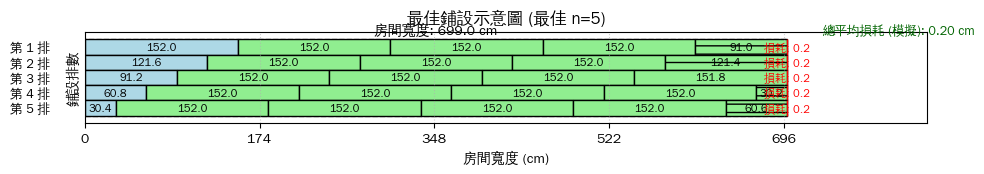

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import os

# 安裝中文字體並清除matplotlib字體緩存
# 檢查是否已安裝字體，避免重複安裝
if not os.path.exists('/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'):
    !apt-get update
    !apt-get install -y fonts-wqy-zenhei
    # 清除matplotlib緩存
    !rm -rf ~/.cache/matplotlib

# 配置 matplotlib 支援中文顯示
mpl.font_manager.fontManager.addfont('/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc')
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei', 'SimHei']  # 優先使用文泉驛正黑，備用SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解決負號顯示為方塊的問題

# 假設 W, L, optimal_n 已從前面的儲存格中定義

if 'W' not in locals() or 'L' not in locals() or 'optimal_n' not in locals() or optimal_n is None:
    print("錯誤: 房間寬度 (W)、地板長度 (L) 或最佳 n (optimal_n) 尚未定義或為 None。請先執行前面的儲存格。")
else:
    fig, ax = plt.subplots(figsize=(10, optimal_n * 0.8))

    # --- 複製 calculate_material_loss 函數中的輔助函數和剩餘材料池邏輯 --- #
    # 這個池將專門儲存來自 『n 個起始塊模式切割』時產生的剩餘材料。
    # 這是規則中「之前開頭分等分時最接近的長度的裁切過的地板尾端來湊」的來源。
    # 並且，這個池是針對這 n 個循環建立的，不會被後續每排起始切割的剩料所填充。
    final_remnant_pool = []
    all_row_losses = [] # 儲存每排實際損耗，用於顯示

    # 輔助函式：將剩餘材料加入池中並保持排序 (由大到小)
    def add_remnant_viz(length):
        if length > 0.001: # 忽略極小的片段，避免浮點數誤差
            final_remnant_pool.append(length)
            final_remnant_pool.sort(reverse=True)

    # 輔助函式：從池中找到最適合填補空間的剩餘材料
    # 最適合的定義為：長度大於或等於 `available_space` 且長度最短接近 `available_space` 的材料
    def get_best_remnant_for_fill_viz(available_space):
        best_remnant_idx = -1
        min_over_cut_length = float('inf') # 尋找超出所需長度最短的材料
        for i, r_len in enumerate(final_remnant_pool):
            if r_len >= available_space: # 必須能夠覆蓋所需空間
                current_over_cut = r_len - available_space
                if current_over_cut < min_over_cut_length: # 選擇超出長度最小的
                    min_over_cut_length = current_over_cut
                    best_remnant_idx = i
        if best_remnant_idx != -1:
            return final_remnant_pool.pop(best_remnant_idx) # 從池中移除並返回
        return None

    # Step 1: 根據「將每一排的第一片地板依照整數分為n等分」的模式，
    # 預先生成這 n 種起始塊的裁切動作，並將其產生的所有 offcuts 放入一個池中。
    # 這個池代表了「之前開頭分等分時」所產生的尾端。
    # 這個池在整個 n 循環模擬過程中，只會被消耗，不會再被新的起始塊切割剩料補充。
    for i in range(optimal_n):
        start_piece_length_for_pattern = L * ((optimal_n - i - 1) % optimal_n + 1) / optimal_n
        offcut_from_pattern_cut = L - start_piece_length_for_pattern
        add_remnant_viz(offcut_from_pattern_cut)
    # --- 剩餘材料池邏輯複製結束 --- #

    # 房間尺寸用於視覺化
    room_width_viz = W
    row_height_viz = L / 10 # 視覺化排高的任意值

    ax.set_xlim(0, room_width_viz * 1.2) # 擴大X軸範圍以容納損耗示意
    ax.set_ylim(-row_height_viz * 0.5, optimal_n * row_height_viz + row_height_viz * 0.5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('房間寬度 (cm)')
    ax.set_ylabel('鋪設排數')
    ax.set_title(f'最佳鋪設示意圖 (最佳 n={optimal_n})')

    # 繪製房間輪廓
    ax.add_patch(patches.Rectangle((0, 0), room_width_viz, optimal_n * row_height_viz, edgecolor='gray', facecolor='none', linestyle='--'))
    ax.text(room_width_viz / 2, optimal_n * row_height_viz + row_height_viz * 0.2, f'房間寬度: {W:.1f} cm', ha='center', va='bottom', fontsize=10)

    for i in range(optimal_n):
        current_x = 0.0 # 當前排已鋪設的長度
        current_y = (optimal_n - 1 - i) * row_height_viz # 從上往下繪製
        current_row_direct_loss = 0.0

        # 確定當前排的起始塊長度。這總是從新的 L 地板切割。
        current_row_start_piece_length = L * ((optimal_n - i - 1) % optimal_n + 1) / optimal_n

        # 繪製起始塊
        ax.add_patch(patches.Rectangle((current_x, current_y), current_row_start_piece_length, row_height_viz, edgecolor='black', facecolor='lightblue'))
        ax.text(current_x + current_row_start_piece_length / 2, current_y + row_height_viz / 2, f'{current_row_start_piece_length:.1f}', ha='center', va='center', fontsize=8)
        current_x += current_row_start_piece_length

        # 中間鋪設盡可能多的整張地板 (L)
        remaining_width_after_start = W - current_x
        num_full_planks = math.floor(remaining_width_after_start / L)
        for j in range(num_full_planks):
            ax.add_patch(patches.Rectangle((current_x, current_y), L, row_height_viz, edgecolor='black', facecolor='lightgreen'))
            ax.text(current_x + L / 2, current_y + row_height_viz / 2, f'{L:.1f}', ha='center', va='center', fontsize=8)
            current_x += L

        # 處理靠牆的最後一塊
        end_piece_needed_length = W - current_x

        if end_piece_needed_length > 0.001: # 仍有空間需要填充 (考慮浮點數誤差)
            # 優先從「起始裁切剩料池」中尋找最適合的材料
            piece_for_end = get_best_remnant_for_fill_viz(end_piece_needed_length)

            if piece_for_end is not None:
                # 使用了剩餘材料填補
                ax.add_patch(patches.Rectangle((current_x, current_y), end_piece_needed_length, row_height_viz, edgecolor='black', facecolor='lightgreen', hatch='--')) # 用虛線表示是剩餘材料
                ax.text(current_x + end_piece_needed_length / 2, current_y + row_height_viz / 2, f'{end_piece_needed_length:.1f}', ha='center', va='center', fontsize=8)
                current_x += end_piece_needed_length
                # 如果剩料比所需長度長，則超出部分是損耗 (不放回池中)
                current_row_direct_loss += max(0, piece_for_end - end_piece_needed_length)
            else:
                # 沒有合適的剩餘材料，使用新的 'L' 地板切割
                cut_length_from_new_plank = min(L, end_piece_needed_length)
                ax.add_patch(patches.Rectangle((current_x, current_y), cut_length_from_new_plank, row_height_viz, edgecolor='black', facecolor='lightgreen'))
                ax.text(current_x + cut_length_from_new_plank / 2, current_y + row_height_viz / 2, f'{cut_length_from_new_plank:.1f}', ha='center', va='center', fontsize=8)
                current_x += cut_length_from_new_plank
                # 從新地板切割產生的剩料 (L - cut_length_from_new_plank) 直接計為損耗，不放回任何池中。
                current_row_direct_loss += (L - cut_length_from_new_plank)

        # 確保鋪設的總長度不會超過房間寬度，任何超出部分都是損耗。
        if current_x > W + 0.001: # 考慮浮點數誤差
            current_row_direct_loss += (current_x - W)
            current_x = W # 將 current_x 限制在房間寬度內，以便視覺化

        all_row_losses.append(current_row_direct_loss)

        # 標示損耗（如果有的話）
        if current_row_direct_loss > 0:
            ax.add_patch(patches.Rectangle((W, current_y), current_row_direct_loss, row_height_viz, edgecolor='red', facecolor='salmon', hatch='///'))
            ax.text(W + current_row_direct_loss / 2, current_y + row_height_viz / 2, f'損耗: {current_row_direct_loss:.1f}', ha='center', va='center', fontsize=8, color='red')

        ax.text(-W*0.05, current_y + row_height_viz / 2, f'第 {i+1} 排', ha='right', va='center', fontsize=9)

    # 顯示未使用的剩餘材料總損耗 (Step 5 of calculate_material_loss)
    total_unused_remnant_loss = sum(final_remnant_pool)
    if total_unused_remnant_loss > 0:
        ax.text(W * 1.05, -row_height_viz * 0.5, f'未使用的剩餘材料總損耗: {total_unused_remnant_loss:.2f} cm', ha='left', va='top', fontsize=9, color='darkred')

    # 顯示總平均損耗 (直接損耗 + 未使用的剩餘材料 / optimal_n)
    total_simulated_loss = sum(all_row_losses) + total_unused_remnant_loss
    average_simulated_loss = total_simulated_loss / optimal_n
    ax.text(W * 1.05, optimal_n * row_height_viz + row_height_viz * 0.2, f'總平均損耗 (模擬): {average_simulated_loss:.2f} cm', ha='left', va='bottom', fontsize=9, color='darkgreen')

    ax.set_xticks(range(0, int(W) + 1, int(W / 4) if W / 4 > 10 else 10))
    ax.set_yticks([]) # 移除 Y 軸刻度以獲得更簡潔的外觀
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

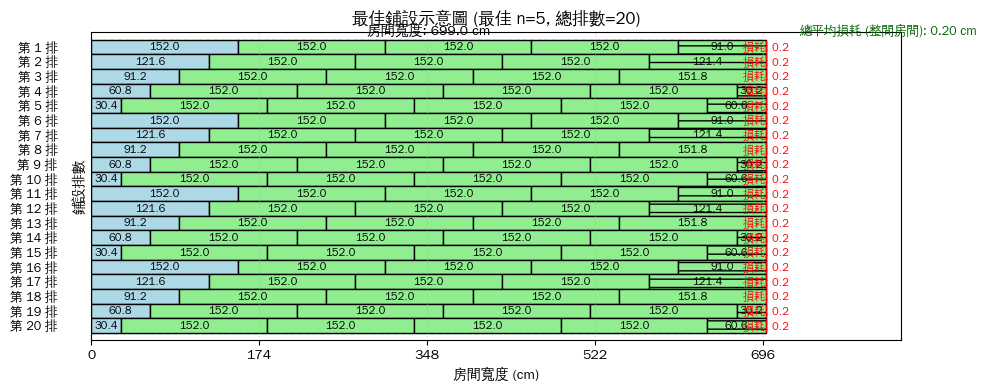

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import os

# 安裝中文字體並清除matplotlib字體緩存
# 檢查是否已安裝字體，避免重複安裝
if not os.path.exists('/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'):
    !apt-get update
    !apt-get install -y fonts-wqy-zenhei
    # 清除matplotlib緩存
    !rm -rf ~/.cache/matplotlib

# 配置 matplotlib 支援中文顯示
mpl.font_manager.fontManager.addfont('/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc')
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei', 'SimHei']  # 優先使用文泉驛正黑，備用SimHei
plt.rcParams['axes.unicode_minus'] = False    # 解決負號顯示為方塊的問題

# 假設 W, L, optimal_n, total_rows 已從前面的儲存格中定義

if 'W' not in locals() or 'L' not in locals() or 'optimal_n' not in locals() or optimal_n is None or 'total_rows' not in locals() or total_rows is None:
    print("錯誤: 房間寬度 (W)、地板長度 (L)、最佳 n (optimal_n) 或總排數 (total_rows) 尚未定義或為 None。請先執行前面的儲存格。")
else:
    fig, ax = plt.subplots(figsize=(10, total_rows * 0.8)) # 1.a 調整圖形大小

    # 初始化總損耗
    total_room_actual_loss = 0.0 # 3. 初始化總損耗

    # --- 複製 calculate_material_loss 函數中的輔助函數和剩餘材料池邏輯 --- #
    # 這個池將專門儲存來自 『n 個起始塊模式切割』時產生的剩餘材料。
    # 這是規則中「之前開頭分等分時最接近的長度的裁切過的地板尾端來湊」的來源。
    # 並且，這個池是針對這 n 個循環建立的，會被後續每排起始切割的剩料所填充。
    # 4. 修改剩餘材料池變數名稱
    current_cycle_remnant_pool = []

    # 輔助函式：將剩餘材料加入池中並保持排序 (由大到小)
    def add_remnant_viz(pool, length):
        if length > 0.001: # 忽略極小的片段，避免浮點數誤差
            pool.append(length)
            pool.sort(reverse=True)

    # 輔助函式：從池中找到最適合填補空間的剩餘材料
    # 最適合的定義為：長度大於或等於 `available_space` 且長度最短接近 `available_space` 的材料
    def get_best_remnant_for_fill_viz(pool, available_space):
        best_remnant_idx = -1
        min_over_cut_length = float('inf') # 尋找超出所需長度最短的材料
        for i, r_len in enumerate(pool):
            if r_len >= available_space: # 必須能夠覆蓋所需空間
                current_over_cut = r_len - available_space
                if current_over_cut < min_over_cut_length: # 選擇超出長度最小的
                    min_over_cut_length = current_over_cut
                    best_remnant_idx = i
        if best_remnant_idx != -1:
            return pool.pop(best_remnant_idx) # 從池中移除並返回
        return None
    # --- 剩餘材料池邏輯複製結束 --- #

    # 房間尺寸用於視覺化
    room_width_viz = W
    row_height_viz = L / 10 # 視覺化排高的任意值

    ax.set_xlim(0, room_width_viz * 1.2) # 擴大X軸範圍以容納損耗示意
    ax.set_ylim(-row_height_viz * 0.5, total_rows * row_height_viz + row_height_viz * 0.5) # 1.b 調整Y軸範圍
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('房間寬度 (cm)')
    ax.set_ylabel('鋪設排數')
    ax.set_title(f'最佳鋪設示意圖 (最佳 n={optimal_n}, 總排數={total_rows})')

    # 繪製房間輪廓
    ax.add_patch(patches.Rectangle((0, 0), room_width_viz, total_rows * row_height_viz, edgecolor='gray', facecolor='none', linestyle='--'))
    ax.text(room_width_viz / 2, total_rows * row_height_viz + row_height_viz * 0.2, f'房間寬度: {W:.1f} cm', ha='center', va='bottom', fontsize=10)

    # 5. 修改主循環為 total_rows
    for i in range(total_rows):
        # 6.a-c 在每個 optimal_n 循環開始時重新初始化剩餘材料池
        if i % optimal_n == 0:
            # 如果不是第一個循環的第一排，將上一個循環未使用的剩料計入總損耗
            if i > 0:
                for r_len in current_cycle_remnant_pool:
                    total_room_actual_loss += r_len
            current_cycle_remnant_pool = [] # 清空池
            # 重新填充 current_cycle_remnant_pool
            for k in range(optimal_n):
                start_piece_length_for_pattern_init = L * ((optimal_n - k - 1) % optimal_n + 1) / optimal_n
                offcut_from_pattern_cut_init = L - start_piece_length_for_pattern_init
                add_remnant_viz(current_cycle_remnant_pool, offcut_from_pattern_cut_init)

        current_x = 0.0 # 當前排已鋪設的長度
        current_y = (total_rows - 1 - i) * row_height_viz # 7. 更新 current_y 計算方式
        current_row_direct_loss = 0.0

        # 確定當前排的起始塊長度。這總是從新的 L 地板切割。
        # 8. 更新起始塊長度計算方式，使其在每個 optimal_n 循環中重複模式
        current_row_start_piece_length = L * ((optimal_n - (i % optimal_n) - 1) % optimal_n + 1) / optimal_n

        # 繪製起始塊
        ax.add_patch(patches.Rectangle((current_x, current_y), current_row_start_piece_length, row_height_viz, edgecolor='black', facecolor='lightblue'))
        ax.text(current_x + current_row_start_piece_length / 2, current_y + row_height_viz / 2, f'{current_row_start_piece_length:.1f}', ha='center', va='center', fontsize=8)
        current_x += current_row_start_piece_length

        # 中間鋪設盡可能多的整張地板 (L)
        remaining_width_after_start = W - current_x
        num_full_planks = math.floor(remaining_width_after_start / L)
        for j in range(num_full_planks):
            ax.add_patch(patches.Rectangle((current_x, current_y), L, row_height_viz, edgecolor='black', facecolor='lightgreen'))
            ax.text(current_x + L / 2, current_y + row_height_viz / 2, f'{L:.1f}', ha='center', va='center', fontsize=8)
            current_x += L

        # 處理靠牆的最後一塊
        end_piece_needed_length = W - current_x

        if end_piece_needed_length > 0.001: # 仍有空間需要填充 (考慮浮點數誤差)
            # 優先從「起始裁切剩料池」中尋找最適合的材料
            piece_for_end = get_best_remnant_for_fill_viz(current_cycle_remnant_pool, end_piece_needed_length)

            if piece_for_end is not None:
                # 使用了剩餘材料填補
                ax.add_patch(patches.Rectangle((current_x, current_y), end_piece_needed_length, row_height_viz, edgecolor='black', facecolor='lightgreen', hatch='--')) # 用虛線表示是剩餘材料
                ax.text(current_x + end_piece_needed_length / 2, current_y + row_height_viz / 2, f'{end_piece_needed_length:.1f}', ha='center', va='center', fontsize=8)
                current_x += end_piece_needed_length
                # 如果剩料比所需長度長，則超出部分是損耗 (不放回池中)
                current_row_direct_loss += max(0, piece_for_end - end_piece_needed_length)
            else:
                # 沒有合適的剩餘材料，使用新的 'L' 地板切割
                cut_length_from_new_plank = min(L, end_piece_needed_length)
                ax.add_patch(patches.Rectangle((current_x, current_y), cut_length_from_new_plank, row_height_viz, edgecolor='black', facecolor='lightgreen'))
                ax.text(current_x + cut_length_from_new_plank / 2, current_y + row_height_viz / 2, f'{cut_length_from_new_plank:.1f}', ha='center', va='center', fontsize=8)
                current_x += cut_length_from_new_plank
                # 從新地板切割產生的剩料 (L - cut_length_from_new_plank) 直接計為損耗，不放回任何池中。
                current_row_direct_loss += (L - cut_length_from_new_plank)

        # 確保鋪設的總長度不會超過房間寬度，任何超出部分都是損耗。
        if current_x > W + 0.001: # 考慮浮點數誤差
            current_row_direct_loss += (current_x - W)
            current_x = W # 將 current_x 限制在房間寬度內，以便視覺化

        # 9. 將每排計算出的損耗加到 total_room_actual_loss
        total_room_actual_loss += current_row_direct_loss

        # 標示損耗（如果有的話）
        if current_row_direct_loss > 0:
            ax.add_patch(patches.Rectangle((W, current_y), current_row_direct_loss, row_height_viz, edgecolor='red', facecolor='salmon', hatch='///'))
            ax.text(W + current_row_direct_loss / 2, current_y + row_height_viz / 2, f'損耗: {current_row_direct_loss:.1f}', ha='center', va='center', fontsize=8, color='red')

        ax.text(-W*0.05, current_y + row_height_viz / 2, f'第 {i+1} 排', ha='right', va='center', fontsize=9)

    # 10. 將最後一個循環中未使用的剩餘材料計入總損耗
    if current_cycle_remnant_pool:
        for r_len in current_cycle_remnant_pool:
            total_room_actual_loss += r_len

    # 11. 計算整個房間的平均損耗
    total_room_average_loss = total_room_actual_loss / total_rows

    # 顯示未使用的剩餘材料總損耗 (這裡顯示的是最後一個循環中未使用的)
    if sum(current_cycle_remnant_pool) > 0:
        ax.text(W * 1.05, -row_height_viz * 0.5, f'最後循環未使用的剩餘材料: {sum(current_cycle_remnant_pool):.2f} cm', ha='left', va='top', fontsize=9, color='darkred')

    # 12.b 顯示整個房間的總平均損耗
    ax.text(W * 1.05, total_rows * row_height_viz + row_height_viz * 0.2, f'總平均損耗 (整間房間): {total_room_average_loss:.2f} cm', ha='left', va='bottom', fontsize=9, color='darkgreen')

    ax.set_xticks(range(0, int(W) + 1, int(W / 4) if W / 4 > 10 else 10))
    ax.set_yticks([]) # 移除 Y 軸刻度以獲得更簡潔的外觀
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()